<a href="https://colab.research.google.com/github/Team-Coders-5-O/Smart-compost-bin/blob/machine-learning/Soil_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q keras


**Imports**

In [ ]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Image Resize & File Path

In [ ]:
Batch_Size=10
Image_Size=(224,224)
train_path='/content/drive/MyDrive/Colab Notebooks/Soil_Images/Train'
valid_path='/content/drive/MyDrive/Colab Notebooks/Soil_Images/Test'

train_dataset=tf.keras.utils.image_dataset_from_directory(train_path,shuffle=True,batch_size=Batch_Size,image_size=Image_Size)
validation_dataset=tf.keras.utils.image_dataset_from_directory(valid_path,shuffle=True,batch_size=Batch_Size,image_size=Image_Size)

Found 67 files belonging to 4 classes.
Found 39 files belonging to 4 classes.


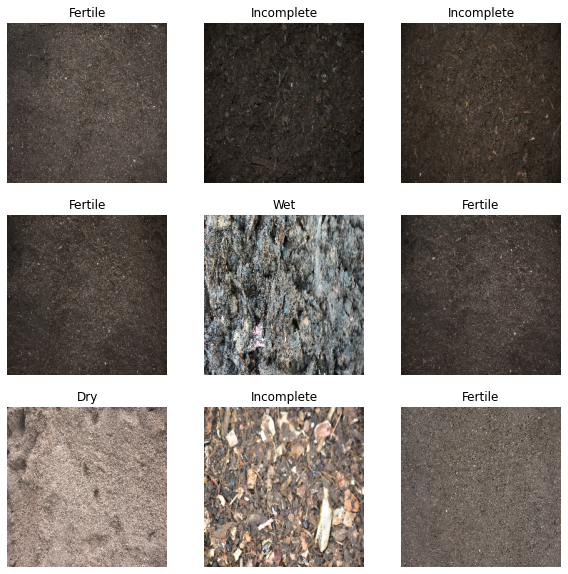

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


Performace Configuration

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

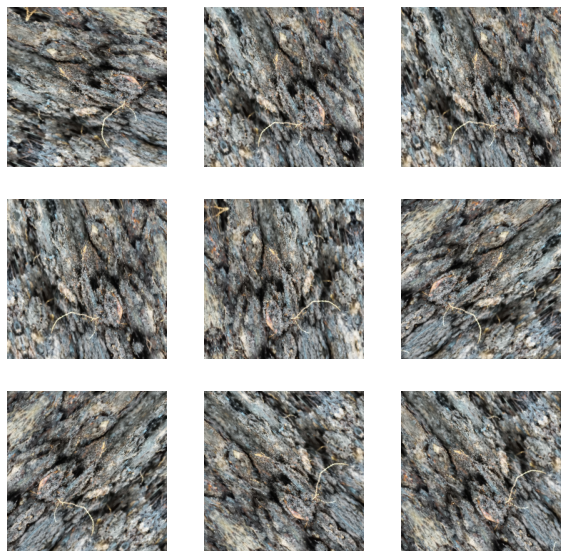

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Pre-Trained Convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
Image_Shape = Image_Size + (3,)
base_model = tf.keras.applications.VGG19(input_shape=Image_Shape,
                                               include_top=False,
                                               weights='imagenet')

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 512)


Feature Extraction

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Classification Head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile Model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

2

Model Train

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 17s 718ms/step - loss: -0.7826 - accuracy: 0.5385


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -0.78
initial accuracy: 0.54


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
7/7 [==============================] - 18s 890ms/step - loss: -2.7042 - accuracy: 0.2090 - val_loss: -0.8398 - val_accuracy: 0.5385
Epoch 2/20
7/7 [==============================] - 14s 567ms/step - loss: -2.6210 - accuracy: 0.1642 - val_loss: -0.8920 - val_accuracy: 0.5128
Epoch 3/20
7/7 [==============================] - 14s 564ms/step - loss: -2.9699 - accuracy: 0.2090 - val_loss: -0.9421 - val_accuracy: 0.4872
Epoch 4/20
7/7 [==============================] - 14s 573ms/step - loss: -3.0731 - accuracy: 0.1791 - val_loss: -0.9879 - val_accuracy: 0.4872
Epoch 5/20
7/7 [==============================] - 14s 567ms/step - loss: -3.0517 - accuracy: 0.1493 - val_loss: -1.0310 - val_accuracy: 0.4615
Epoch 6/20
7/7 [==============================] - 14s 555ms/step - loss: -2.9871 - accuracy: 0.2090 - val_loss: -1.0727 - val_accuracy: 0.4359
Epoch 7/20
7/7 [==============================] - 14s 579ms/step - loss: -3.2976 - accuracy: 0.2836 - val_loss: -1.1123 - val_accuracy: 0.4359

Graph Plot

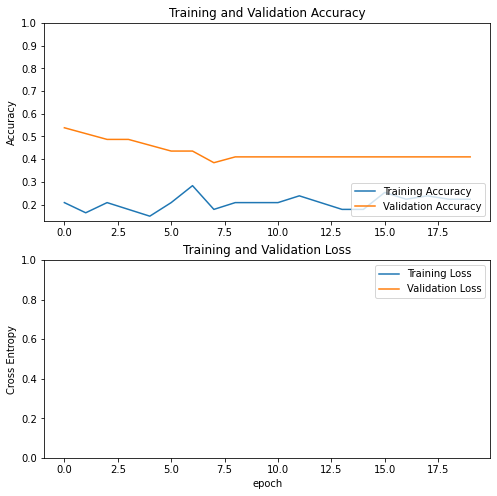

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()